In [ ]:
!pip install bertviz

In [ ]:
from transformers import AutoTokenizer, AutoModel
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show


In [ ]:
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = 'time flies like an arrow'
show(model, 'bert', tokenizer, text, display_mode = 'light', layer = 0, head = 8)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

NameError: name 'BertModel' is not defined

In [ ]:
text = 'time flies like an arrow'
inputs = tokenizer(text, return_tensors = 'pt', add_special_tokens = False) #add_special_tokens = False will eliminate [CLS] and [SEP] token.
inputs.input_ids


tensor([[ 2051, 10029,  2066,  2019,  8612]])

In [ ]:
from torch import nn
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

<code>AutoConfig</code> class is used to load the config.json file associated with the bert-uncase-based checkpoint. This file specifies specific hyperparameters like vocab_size and hidden_size. Then each input ID will be mapped to one of 30522 vectors, each with a size of 768. The token embeddings here are independent of their context.



In [ ]:
input_embs = token_emb(inputs.input_ids)
input_embs.size()

torch.Size([1, 5, 768])

In [ ]:
import torch
from math import sqrt

query = key = value = input_embs
dim_k = key.size(-1) #768 in this case
scores = torch.bmm(query, key.transpose(1,2))/sqrt(dim_k)
scores.size()

torch.Size([1, 5, 5])

A **(5x5) matrix** is of attention scores is created per sample in the batch. We now see Query, Key, and Value is not multiplied with repsective weight matrix, but keep equal. This is for the simplicity of the illustration.

In [ ]:
import torch.nn.functional as F

weights = F.softmax(scores, dim = -1)
#Check that the weight values is sum up to 1
weights.sum(dim = -1)


tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

In [ ]:
attn_outputs = torch.bmm(weights, value)
attn_outputs.shape
#The output have the same dimension as the input embedding vector. But the values are 'updated' with contextual information.

torch.Size([1, 5, 768])

In [ ]:
#warp up these calculations into a function
def scaled_dot_product_attention(query, key, value):
  #retrieve the dimension of key matrix
  dim_k = key.size(-1)

  #compute batch-matrix-multiplication
    #Q(batch_size, seq_len, head_dim)
    #K_transpose(head_dim, seq_len, batch_size)
    #Dot product of Q and K_transpose is a matrix of (batch_size, seq_len, seq_len)
  scores = torch.bmm(query, key.transpose(1,2))/sqrt(dim_k) #

  #Soft-max transform to have attention score matrix
  weights = F.softmax(scores, dim = -1)

  #Multiplied weights with value to 'update' the value of input hidden_states
  return torch.bmm(weights, value)

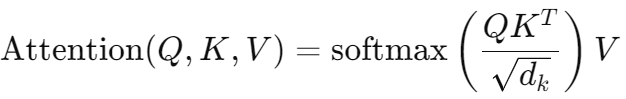

<h2> Multi-headed attention</h2>

In [ ]:
class AttentionHead(nn.Module):
  def __init__(self, embed_dim, head_dim):
    # Initializes the Attention Head.
    # embed_dim: The input embedding size (768 in BERT)
    # head_dim: The output embedding size (768/12 = 64 in BERT)
    super().__init__()

    #Linear layers for Query, Key, and Value transformation
    #nn.Linear is dense linear layer, such as keras.layers.Dense in Tesorflow
    self.q = nn.Linear(embed_dim, head_dim) # Projects embeddings to Queries
    self.k = nn.Linear(embed_dim, head_dim) # Projects embeddings to Keys
    self.v = nn.Linear(embed_dim, head_dim) # Projects embeddings to Values

  def forward(self, hidden_state):
    # Forward Input:
    # Hidden_state: Input tensor of shape [batch_size, seq_len, embed_dim]
    # Output:
    # attn_outputs: Tensor of shape [batch_size, seq_len, head_dim]
    # Transformation:
    #Transform input matrix input output matrix (for each projection)
    attn_outputs =  scaled_dot_product_attention(
        self.q(hidden_state), self.k(hidden_state), self.v(hidden_state)
    )
    return attn_outputs

Here, we initialized 3 independent linear layers that applied the matrix multiplication to transform the embedding vector `(batch_size, seq_len, embedd_dim)` into a tensors of shape `(batch_size, seq_len, head_dim)`. Then, we can concatenate the outputs of each one to implement the full multi-head attention layer:

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Step 1: Extract model hyperparameters from `config`
        embed_dim = config.hidden_size       # Total embedding size (e.g., 768 for BERT)
        num_heads = config.num_attention_heads  # Number of attention heads (e.g., 12 for BERT)
        head_dim = embed_dim // num_heads    # Dimension of each individual attention head

        # Step 2: Initialize multiple attention heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )

        # Step 3: Linear projection to combine all attention head outputs
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        """
        Forward pass through Multi-Head Attention.

        Args:
        - hidden_state: Tensor of shape [batch_size, seq_len, embed_dim]

        Returns:
        - Tensor of shape [batch_size, seq_len, embed_dim]
        """

        # Step 4: Apply each attention head independently
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)

        # Step 5: Project back to the original embedding dimension
        x = self.output_linear(x)

        return x


In [ ]:
multihead_attn = MultiHeadAttention(config)
attn_outputs = multihead_attn(input_embs)

In [ ]:
attn_outputs.size()

torch.Size([1, 5, 768])

In [ ]:
#Use BERT again to visualize 2 different uses of the word "flies"

In [ ]:
from bertviz import head_view
from transformers import AutoModel
model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)
sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"
viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])
head_view(attention, tokens, sentence_b_start, heads=[8])

ModuleNotFoundError: No module named 'bertviz'

<h1> Feed forward layer

After the self-attention mechanism has processed the input embeddings, the next step is to apply a feed-forward neural network (FFN).
The feed-forward sublayer in the encoder and decoder is just a simple two-layer fully
connected neural network, but with a twist: instead of processing the whole sequence
of embeddings as a single vector, it processes each embedding independently. This mechanism ensures that each token embedding in the sequence undergoes the same transformation without mixing information between tokens.

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
    self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout(config.hidden_dropout_prob)

  def forward(self, x):
    x = self.linear_1(x)
    x = self.gelu(x)
    x = self.linear_2(x)
    x = self.dropout(x)
    return x

In [ ]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_outputs)
ff_outputs.size()

torch.Size([1, 5, 768])

<h2>Adding Layer Normalization</h2>

2 new concept of this part: Normalization layer and Skip Connection

In [ ]:
class TransformersEncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
    self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
    self.attention = MultiHeadAttention(config)
    self.feed_forward = FeedForward(config)
  def forward(self, x):
    #Apply layer normalization and then copy the input into query, key, and value
    hidden_state = self.layer_norm_1(x)
    #apply attention with a skip connection
    x = x + self.attention(hidden_state)
    x = x + self.feed_forward(self.layer_norm_2(x))
    return x

In [ ]:
encoder_layer = TransformersEncoderLayer(config)
input_embs.shape, encoder_layer(input_embs).shape

(torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))

<h2>Positional Encoder</h2>

In [ ]:
class Embeddings(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
    self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
    self.layer_norm = nn.LayerNorm(config.hidden_size, eps = 1e-12)
    self.dropout = nn.Dropout()

  def forward(self, input_ids):
    #Create a position IDs for input sequence:
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype = torch.long).unsqueeze(0)

    #Create token and position embeddings:
    token_embeddings = self.token_embeddings(input_ids)
    position_embeddings = self.position_embeddings(position_ids)

    #Combine token and position embeddings:
    embeddings = token_embeddings + position_embeddings
    embeddings = self.layer_norm(embeddings)
    embeddings = self.dropout(embeddings)
    return embeddings
embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()

torch.Size([1, 5, 768])

<h2>Combining Embedding and Encoding Layers</h2>

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.embeddings = Embeddings(config)
    self.layers = nn.ModuleList([TransformersEncoderLayer(config) for _ in range(config.num_hidden_layers)])

  def forward(self, x):
    x = self.embeddings(x)
    for layer in self.layers: #Forward through each [layer_norm, multihead_attention, layer_norm2, Position-wise FFNN] encoder block
      x = layer(x)
    return x

In [ ]:
transformer_encoding = TransformerEncoder(config)
transformer_encoding(inputs.input_ids).size()

torch.Size([1, 5, 768])

<h2> Adding Classification Head</h2>

In [ ]:
class TransformerEncoder_ClassificationHead(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.Encoder = TransformerEncoder(config)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.Classification_head = nn.Linear(config.hidden_size, config.num_labels)

  def forward(self, x):
    x = self.Encoder(x)[:,0,:] #extract only [CLS token] from [batch_size, tok_num, tok_embs]
    x = self.dropout(x)
    x = self.Classification_head(x)
    return x

In [ ]:
#Define num_labels from config
config.num_labels = 3
encoder_classifier = TransformerEncoder_ClassificationHead(config)
encoder_classifier(inputs.input_ids).size()

torch.Size([1, 3])